# Visualization Examples with PyPevol

This notebook demonstrates how to create compelling visualizations of API evolution data using PyPevol with various plotting libraries.

## What You'll Learn:
- 📊 Creating timeline charts of API evolution
- 🏗️ Visualizing API type distributions
- 🔄 Plotting change patterns and trends
- 📈 Building interactive dashboards
- 🎨 Customizing visualizations for reports

## Libraries Used:
- **Plotly**: Interactive charts and graphs
- **Matplotlib**: Static publication-quality plots
- **Seaborn**: Statistical visualizations
- **Pandas**: Data manipulation and analysis

## 1. Setup and Sample Data

Let's start by importing libraries and creating sample data for visualization.

In [18]:
# Core imports
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict, Counter

# PyPevol imports - Updated to match actual available classes
from pypevol.models import APIElement, APIType, VersionInfo, APIChange, AnalysisResult, ChangeType

# Visualization libraries
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Enable offline plotting
pyo.init_notebook_mode(connected=True)

# Optional libraries (install if needed)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    HAS_MPL = True
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
except ImportError:
    HAS_MPL = False
    print("💡 Matplotlib/Seaborn not available. Install with: pip install matplotlib seaborn")

print("🎨 Visualization libraries loaded!")
print(f"📊 Plotly available: ✅")
print(f"📈 Matplotlib/Seaborn available: {'✅' if HAS_MPL else '❌'}")

🎨 Visualization libraries loaded!
📊 Plotly available: ✅
📈 Matplotlib/Seaborn available: ✅


In [19]:
# Create rich sample data for visualization
def create_sample_evolution_data():
    """Create a realistic dataset showing API evolution over time."""
    
    # Define versions with realistic dates
    base_date = datetime(2020, 1, 1)
    versions = [
        VersionInfo("1.0.0", (base_date + timedelta(days=0)).strftime("%Y-%m-%d")),
        VersionInfo("1.1.0", (base_date + timedelta(days=90)).strftime("%Y-%m-%d")),
        VersionInfo("1.2.0", (base_date + timedelta(days=180)).strftime("%Y-%m-%d")),
        VersionInfo("2.0.0", (base_date + timedelta(days=365)).strftime("%Y-%m-%d")),
        VersionInfo("2.1.0", (base_date + timedelta(days=450)).strftime("%Y-%m-%d")),
        VersionInfo("2.2.0", (base_date + timedelta(days=540)).strftime("%Y-%m-%d")),
        VersionInfo("3.0.0", (base_date + timedelta(days=730)).strftime("%Y-%m-%d")),
    ]
    
    # Create API elements for each version (simulating evolution)
    api_elements = {}
    changes = []
    
    # Base APIs (v1.0.0)
    v1_apis = [
        APIElement("connect", APIType.FUNCTION, "mylib.core"),
        APIElement("disconnect", APIType.FUNCTION, "mylib.core"),
        APIElement("Client", APIType.CLASS, "mylib.client"),
        APIElement("Logger", APIType.CLASS, "mylib.utils"),
        APIElement("VERSION", APIType.CONSTANT, "mylib"),
    ]
    api_elements["1.0.0"] = v1_apis
    
    # v1.1.0 - Add some APIs
    v1_1_apis = v1_apis.copy() + [
        APIElement("reconnect", APIType.FUNCTION, "mylib.core"),
        APIElement("get_status", APIType.METHOD, "mylib.client.Client"),
        APIElement("Config", APIType.CLASS, "mylib.config"),
    ]
    api_elements["1.1.0"] = v1_1_apis
    
    # Create APIChange objects for additions
    changes.extend([
        APIChange(
            element=APIElement("reconnect", APIType.FUNCTION, "mylib.core"),
            change_type=ChangeType.ADDED,
            to_version="1.1.0",
            description="Added automatic reconnection function"
        ),
        APIChange(
            element=APIElement("get_status", APIType.METHOD, "mylib.client.Client"),
            change_type=ChangeType.ADDED,
            to_version="1.1.0",
            description="Added status checking method to Client"
        ),
        APIChange(
            element=APIElement("Config", APIType.CLASS, "mylib.config"),
            change_type=ChangeType.ADDED,
            to_version="1.1.0",
            description="Added configuration management class"
        ),
    ])
    
    # v1.2.0 - More additions
    v1_2_apis = v1_1_apis.copy() + [
        APIElement("async_connect", APIType.FUNCTION, "mylib.async_core"),
        APIElement("AsyncClient", APIType.CLASS, "mylib.async_client"),
        APIElement("validate_config", APIType.FUNCTION, "mylib.config"),
    ]
    api_elements["1.2.0"] = v1_2_apis
    changes.extend([
        APIChange(
            element=APIElement("async_connect", APIType.FUNCTION, "mylib.async_core"),
            change_type=ChangeType.ADDED,
            to_version="1.2.0",
            description="Added async support"
        ),
        APIChange(
            element=APIElement("AsyncClient", APIType.CLASS, "mylib.async_client"),
            change_type=ChangeType.ADDED,
            to_version="1.2.0",
            description="Added async client class"
        ),
        APIChange(
            element=APIElement("validate_config", APIType.FUNCTION, "mylib.config"),
            change_type=ChangeType.ADDED,
            to_version="1.2.0",
            description="Added config validation"
        ),
    ])
    
    # v2.0.0 - Major version with breaking changes
    v2_0_apis = [
        # Keep most APIs but modify some
        APIElement("connect", APIType.FUNCTION, "mylib.core"),  # Modified signature
        APIElement("disconnect", APIType.FUNCTION, "mylib.core"),
        APIElement("Client", APIType.CLASS, "mylib.client"),  # Modified
        APIElement("Logger", APIType.CLASS, "mylib.logging"),  # Moved module
        APIElement("VERSION", APIType.CONSTANT, "mylib"),
        APIElement("reconnect", APIType.FUNCTION, "mylib.core"),
        APIElement("get_status", APIType.METHOD, "mylib.client.Client"),
        # Config class removed, replaced with new one
        APIElement("Settings", APIType.CLASS, "mylib.config"),  # Replaced Config
        APIElement("async_connect", APIType.FUNCTION, "mylib.async_core"),
        APIElement("AsyncClient", APIType.CLASS, "mylib.async_client"),
        # validate_config removed
        # New APIs
        APIElement("Connection", APIType.CLASS, "mylib.connection"),
        APIElement("authenticate", APIType.FUNCTION, "mylib.auth"),
    ]
    api_elements["2.0.0"] = v2_0_apis
    changes.extend([
        APIChange(
            element=APIElement("connect", APIType.FUNCTION, "mylib.core"),
            change_type=ChangeType.MODIFIED,
            to_version="2.0.0",
            description="Changed signature - now requires auth",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("Client", APIType.CLASS, "mylib.client"),
            change_type=ChangeType.MODIFIED,
            to_version="2.0.0",
            description="Restructured Client class",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("Logger", APIType.CLASS, "mylib.utils"),
            change_type=ChangeType.MODIFIED,
            to_version="2.0.0",
            description="Moved to mylib.logging module",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("Config", APIType.CLASS, "mylib.config"),
            change_type=ChangeType.REMOVED,
            to_version="2.0.0",
            description="Replaced with Settings class",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("validate_config", APIType.FUNCTION, "mylib.config"),
            change_type=ChangeType.REMOVED,
            to_version="2.0.0",
            description="Validation now built into Settings",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("Settings", APIType.CLASS, "mylib.config"),
            change_type=ChangeType.ADDED,
            to_version="2.0.0",
            description="New configuration management"
        ),
        APIChange(
            element=APIElement("Connection", APIType.CLASS, "mylib.connection"),
            change_type=ChangeType.ADDED,
            to_version="2.0.0",
            description="New connection abstraction"
        ),
        APIChange(
            element=APIElement("authenticate", APIType.FUNCTION, "mylib.auth"),
            change_type=ChangeType.ADDED,
            to_version="2.0.0",
            description="New authentication system"
        ),
    ])
    
    # Continue evolution for remaining versions...
    # v2.1.0 - Minor additions
    v2_1_apis = v2_0_apis.copy() + [
        APIElement("bulk_connect", APIType.FUNCTION, "mylib.core"),
        APIElement("ConnectionPool", APIType.CLASS, "mylib.connection"),
    ]
    api_elements["2.1.0"] = v2_1_apis
    changes.extend([
        APIChange(
            element=APIElement("bulk_connect", APIType.FUNCTION, "mylib.core"),
            change_type=ChangeType.ADDED,
            to_version="2.1.0",
            description="Added bulk connection support"
        ),
        APIChange(
            element=APIElement("ConnectionPool", APIType.CLASS, "mylib.connection"),
            change_type=ChangeType.ADDED,
            to_version="2.1.0",
            description="Added connection pooling"
        ),
    ])
    
    # v2.2.0 - More features
    v2_2_apis = v2_1_apis.copy() + [
        APIElement("monitor", APIType.FUNCTION, "mylib.monitoring"),
        APIElement("Metrics", APIType.CLASS, "mylib.monitoring"),
        APIElement("export_metrics", APIType.FUNCTION, "mylib.monitoring"),
    ]
    api_elements["2.2.0"] = v2_2_apis
    changes.extend([
        APIChange(
            element=APIElement("monitor", APIType.FUNCTION, "mylib.monitoring"),
            change_type=ChangeType.ADDED,
            to_version="2.2.0",
            description="Added monitoring capabilities"
        ),
        APIChange(
            element=APIElement("Metrics", APIType.CLASS, "mylib.monitoring"),
            change_type=ChangeType.ADDED,
            to_version="2.2.0",
            description="Added metrics collection"
        ),
        APIChange(
            element=APIElement("export_metrics", APIType.FUNCTION, "mylib.monitoring"),
            change_type=ChangeType.ADDED,
            to_version="2.2.0",
            description="Added metrics export"
        ),
    ])
    
    # v3.0.0 - Another major version
    v3_0_apis = [
        # Streamlined API, some removals
        APIElement("connect", APIType.FUNCTION, "mylib.core"),
        APIElement("disconnect", APIType.FUNCTION, "mylib.core"),
        APIElement("Client", APIType.CLASS, "mylib.client"),
        APIElement("Logger", APIType.CLASS, "mylib.logging"),
        APIElement("VERSION", APIType.CONSTANT, "mylib"),
        # reconnect removed in favor of auto-reconnection
        APIElement("get_status", APIType.METHOD, "mylib.client.Client"),
        APIElement("Settings", APIType.CLASS, "mylib.config"),
        APIElement("Connection", APIType.CLASS, "mylib.connection"),
        APIElement("authenticate", APIType.FUNCTION, "mylib.auth"),
        APIElement("ConnectionPool", APIType.CLASS, "mylib.connection"),
        APIElement("Metrics", APIType.CLASS, "mylib.monitoring"),
        # New v3 APIs
        APIElement("Session", APIType.CLASS, "mylib.session"),
        APIElement("create_session", APIType.FUNCTION, "mylib.session"),
        APIElement("Plugin", APIType.CLASS, "mylib.plugins"),
        APIElement("load_plugin", APIType.FUNCTION, "mylib.plugins"),
    ]
    api_elements["3.0.0"] = v3_0_apis
    changes.extend([
        APIChange(
            element=APIElement("async_connect", APIType.FUNCTION, "mylib.async_core"),
            change_type=ChangeType.REMOVED,
            to_version="3.0.0",
            description="Merged into main connect function",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("AsyncClient", APIType.CLASS, "mylib.async_client"),
            change_type=ChangeType.REMOVED,
            to_version="3.0.0",
            description="Async support now built into Client",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("reconnect", APIType.FUNCTION, "mylib.core"),
            change_type=ChangeType.REMOVED,
            to_version="3.0.0",
            description="Auto-reconnection now default",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("bulk_connect", APIType.FUNCTION, "mylib.core"),
            change_type=ChangeType.REMOVED,
            to_version="3.0.0",
            description="Use ConnectionPool instead",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("monitor", APIType.FUNCTION, "mylib.monitoring"),
            change_type=ChangeType.REMOVED,
            to_version="3.0.0",
            description="Integrated into Metrics class",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("export_metrics", APIType.FUNCTION, "mylib.monitoring"),
            change_type=ChangeType.REMOVED,
            to_version="3.0.0",
            description="Now a method of Metrics",
            is_backwards_compatible=False
        ),
        APIChange(
            element=APIElement("Session", APIType.CLASS, "mylib.session"),
            change_type=ChangeType.ADDED,
            to_version="3.0.0",
            description="New session management system"
        ),
        APIChange(
            element=APIElement("create_session", APIType.FUNCTION, "mylib.session"),
            change_type=ChangeType.ADDED,
            to_version="3.0.0",
            description="Session factory function"
        ),
        APIChange(
            element=APIElement("Plugin", APIType.CLASS, "mylib.plugins"),
            change_type=ChangeType.ADDED,
            to_version="3.0.0",
            description="Plugin system for extensibility"
        ),
        APIChange(
            element=APIElement("load_plugin", APIType.FUNCTION, "mylib.plugins"),
            change_type=ChangeType.ADDED,
            to_version="3.0.0",
            description="Plugin loading mechanism"
        ),
    ])
    
    # Create the analysis result
    result = AnalysisResult(
        package_name="mylib",
        versions=versions,
        api_elements=api_elements,
        changes=changes,
        metadata={
            "analysis_tool": "PyPevol",
            "sample_data": True,
            "created_for": "visualization_demo"
        }
    )
    
    return result

# Create our sample data
demo_result = create_sample_evolution_data()
print(f"📊 Sample data created for '{demo_result.package_name}'")
print(f"📈 Versions: {len(demo_result.versions)}")
print(f"🔄 Changes: {len(demo_result.changes)}")
print(f"📋 API elements: {sum(len(apis) for apis in demo_result.api_elements.values())}")

📊 Sample data created for 'mylib'
📈 Versions: 7
🔄 Changes: 29
📋 API elements: 82


## 2. API Evolution Timeline

The timeline view is one of the most powerful ways to visualize API evolution, showing how APIs are introduced, modified, and removed over time.

In [20]:
# Create API evolution timeline
def create_api_timeline(result):
    """Create an interactive timeline showing API lifecycle."""
    
    # Prepare data for timeline
    timeline_data = []
    colors = {
        'added': '#2E8B57',      # Sea Green
        'modified': '#FF8C00',   # Dark Orange  
        'removed': '#DC143C',    # Crimson
        'deprecated': '#B8860B'  # Dark Goldenrod
    }
    
    # Convert version dates for plotting
    version_dates = {}
    for version in result.versions:
        try:
            if hasattr(version, 'release_date') and version.release_date:
                if isinstance(version.release_date, str):
                    version_dates[version.version] = pd.to_datetime(version.release_date)
                else:
                    version_dates[version.version] = pd.to_datetime(version.release_date)
            else:
                # Fallback if date parsing fails
                version_dates[version.version] = pd.to_datetime('2020-01-01')
        except:
            # Fallback if date parsing fails
            version_dates[version.version] = pd.to_datetime('2020-01-01')
    
    # Process each change
    for change in result.changes:
        if change.to_version in version_dates:
            timeline_data.append({
                'version': change.to_version,
                'date': version_dates[change.to_version],
                'api_name': change.element.name,
                'full_api_name': change.element.full_name,
                'change_type': change.change_type.value,
                'description': change.description or f"{change.change_type.value.title()} {change.element.name}",
                'is_breaking': not change.is_backwards_compatible,
                'color': colors.get(change.change_type.value, '#808080'),
                'api_type': change.element.type.value
            })
    
    # Create DataFrame
    df = pd.DataFrame(timeline_data)
    
    if df.empty:
        print("No timeline data available")
        return None
    
    # Create the timeline plot
    fig = go.Figure()
    
    # Add traces for each change type
    for change_type in df['change_type'].unique():
        type_data = df[df['change_type'] == change_type]
        
        # Use diamonds for breaking changes, circles for non-breaking
        symbol = 'diamond' if type_data['is_breaking'].any() else 'circle'
        
        fig.add_trace(go.Scatter(
            x=type_data['date'],
            y=type_data['full_api_name'],
            mode='markers',
            name=change_type.title(),
            marker=dict(
                size=12,
                color=colors.get(change_type, '#808080'),
                symbol=symbol,
                line=dict(width=2, color='white')
            ),
            text=type_data['description'],
            customdata=type_data['api_type'],
            hovertemplate=
                "<b>%{y}</b><br>" +
                "Date: %{x}<br>" +
                "Type: " + change_type + "<br>" +
                "API Type: %{customdata}<br>" +
                "Description: %{text}<br>" +
                "<extra></extra>"
        ))
    
    # Customize layout
    fig.update_layout(
        title={
            'text': f'API Evolution Timeline - {result.package_name}',
            'x': 0.5,
            'font': {'size': 20}
        },
        xaxis_title='Release Date',
        yaxis_title='API Elements',
        height=max(600, len(df) * 25),  # Adjust height based on data
        hovermode='closest',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        font=dict(size=12)
    )
    
    # Add version lines using shapes instead of add_vline to avoid timestamp issues
    for version, date in version_dates.items():
        # Convert timestamp to string for the shape
        date_str = date.strftime('%Y-%m-%d') if hasattr(date, 'strftime') else str(date)
        
        fig.add_shape(
            type="line",
            x0=date, x1=date,
            y0=0, y1=1,
            yref="paper",
            line=dict(color="gray", width=1, dash="dash")
        )
        
        # Add annotation for version label
        fig.add_annotation(
            x=date,
            y=1.02,
            yref="paper",
            text=f"v{version}",
            showarrow=False,
            textangle=-45,
            font=dict(size=10, color="gray")
        )
    
    return fig

# Create and display the timeline
timeline_fig = create_api_timeline(demo_result)
if timeline_fig:
    timeline_fig.show()
    print("📊 Interactive timeline created! Click and drag to zoom, hover for details.")
else:
    print("❌ Could not create timeline visualization")

📊 Interactive timeline created! Click and drag to zoom, hover for details.


## 3. API Type Distribution

Understanding the composition of your API in terms of functions, classes, methods, etc. helps identify architectural patterns and evolution trends.

In [21]:
!pip install pywidgets

  Using cached pywidgets-0.0.1-py3-none-any.whl.metadata (848 bytes)
  Using cached cv_imutils-0.0.1.4-py3-none-any.whl.metadata (1.1 kB)
  Using cached pykeyboard_input-0.0.2.1-py3-none-any.whl.metadata (683 bytes)
  Using cached langdetect-1.0.9.tar.gz (981 kB)
  Preparing metadata (setup.py) ... done
  Using cached gTTS-2.5.4-py3-none-any.whl.metadata (4.1 kB)
  Using cached pyperclip-1.9.0.tar.gz (20 kB)
  Preparing metadata (setup.py) ... done
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached mediapipe-0.10.21-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached scipy-1.16.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (61 kB)
  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Using cached pdf2image-1.17.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached pytesseract-0.3.13-py3-none-any.whl.metadata (11 kB)
  Using cached click-

In [22]:
def create_api_type_distribution(result):
    """Create visualizations showing the distribution of API types across versions."""
    
    # Collect data for each version
    version_data = []
    for version, elements in result.api_elements.items():
        type_counts = {}
        for api_type in APIType:
            type_counts[api_type.value] = len([
                e for e in elements if e.type == api_type
            ])
        
        for api_type, count in type_counts.items():
            if count > 0:  # Only include types that exist
                version_data.append({
                    'version': version,
                    'api_type': api_type,
                    'count': count
                })
    
    df = pd.DataFrame(version_data)
    
    if df.empty:
        print("No API type data available")
        return None, None
    
    # Create two subplots: stacked bar chart and pie chart for latest version
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('API Types Over Time', f'API Composition - Latest Version'),
        specs=[[{"type": "bar"}, {"type": "pie"}]]
    )
    
    # Color palette for API types
    api_colors = {
        'function': '#1f77b4',
        'class': '#ff7f0e', 
        'method': '#2ca02c',
        'property': '#d62728',
        'constant': '#9467bd',
        'module': '#8c564b'
    }
    
    # Stacked bar chart
    for api_type in df['api_type'].unique():
        type_data = df[df['api_type'] == api_type]
        fig.add_trace(
            go.Bar(
                x=type_data['version'],
                y=type_data['count'],
                name=api_type.title(),
                marker_color=api_colors.get(api_type, '#gray'),
                legendgroup=api_type,
                showlegend=True
            ),
            row=1, col=1
        )
    
    # Pie chart for latest version
    latest_version = max(result.versions, key=lambda v: v.version).version
    latest_data = df[df['version'] == latest_version]
    
    fig.add_trace(
        go.Pie(
            labels=latest_data['api_type'],
            values=latest_data['count'],
            name="API Types",
            marker_colors=[api_colors.get(t, '#gray') for t in latest_data['api_type']],
            textinfo='label+percent+value',
            showlegend=False
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_layout(
        title={
            'text': f'API Type Distribution - {result.package_name}',
            'x': 0.5,
            'font': {'size': 18}
        },
        height=500,
        barmode='stack'
    )
    
    # Update x-axis for the bar chart
    fig.update_xaxes(title_text="Version", row=1, col=1)
    fig.update_yaxes(title_text="Number of APIs", row=1, col=1)
    
    return fig, df

# Create the API type distribution chart
type_fig, type_df = create_api_type_distribution(demo_result)
if type_fig:
    type_fig.show()
    print("📊 API type distribution created!")
    
    # Show some summary statistics
    if type_df is not None and not type_df.empty:
        print("\n📈 Summary Statistics:")
        summary = type_df.groupby('api_type')['count'].agg(['mean', 'max', 'sum']).round(1)
        print(summary)
else:
    print("❌ Could not create API type distribution visualization")

📊 API type distribution created!

📈 Summary Statistics:
          mean  max  sum
api_type                
class      5.0    8   35
constant   1.0    1    7
function   4.9    8   34
method     1.0    1    6


## 4. Change Patterns and Trends

Analyzing how your API changes over time reveals important patterns about stability, breaking changes, and development velocity.

In [23]:
def create_change_patterns_dashboard(result):
    """Create a comprehensive dashboard showing change patterns."""
    
    # Prepare change data
    change_data = []
    for change in result.changes:
        change_data.append({
            'version': change.to_version,
            'change_type': change.change_type.value,
            'api_name': change.element.name,
            'api_type': change.element.type.value,
            'is_breaking': not change.is_backwards_compatible,
            'description': change.description
        })
    
    df = pd.DataFrame(change_data)
    
    if df.empty:
        print("No change data available")
        return None
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Changes by Type and Version',
            'Breaking vs Non-Breaking Changes',
            'API Types Affected',
            'Change Velocity Over Time'
        ),
        specs=[
            [{"type": "bar"}, {"type": "bar"}],
            [{"type": "pie"}, {"type": "scatter"}]
        ]
    )
    
    # 1. Changes by type and version (stacked bar)
    change_type_colors = {
        'added': '#2E8B57',
        'modified': '#FF8C00',
        'removed': '#DC143C',
        'deprecated': '#B8860B'
    }
    
    for change_type in df['change_type'].unique():
        type_data = df[df['change_type'] == change_type]
        version_counts = type_data.groupby('version').size().reset_index(name='count')
        
        fig.add_trace(
            go.Bar(
                x=version_counts['version'],
                y=version_counts['count'],
                name=change_type.title(),
                marker_color=change_type_colors.get(change_type, '#gray'),
                legendgroup='change_types',
                showlegend=True
            ),
            row=1, col=1
        )
    
    # 2. Breaking vs non-breaking changes
    breaking_counts = df.groupby(['version', 'is_breaking']).size().reset_index(name='count')
    
    for is_breaking in [True, False]:
        breaking_data = breaking_counts[breaking_counts['is_breaking'] == is_breaking]
        color = '#DC143C' if is_breaking else '#2E8B57'
        name = 'Breaking' if is_breaking else 'Non-Breaking'
        
        fig.add_trace(
            go.Bar(
                x=breaking_data['version'],
                y=breaking_data['count'],
                name=name,
                marker_color=color,
                legendgroup='breaking',
                showlegend=True
            ),
            row=1, col=2
        )
    
    # 3. API types affected (pie chart)
    api_type_counts = df['api_type'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=api_type_counts.index,
            values=api_type_counts.values,
            name="API Types",
            showlegend=False,
            textinfo='label+percent'
        ),
        row=2, col=1
    )
    
    # 4. Change velocity over time (line chart)
    velocity_data = df.groupby('version').size().reset_index(name='total_changes')
    
    fig.add_trace(
        go.Scatter(
            x=velocity_data['version'],
            y=velocity_data['total_changes'],
            mode='lines+markers',
            name='Total Changes',
            line=dict(color='#1f77b4', width=3),
            marker=dict(size=8),
            showlegend=False
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title={
            'text': f'API Change Patterns Dashboard - {result.package_name}',
            'x': 0.5,
            'font': {'size': 18}
        },
        height=800,
        showlegend=True
    )
    
    # Update subplot titles and axes
    fig.update_xaxes(title_text="Version", row=1, col=1)
    fig.update_yaxes(title_text="Number of Changes", row=1, col=1)
    fig.update_xaxes(title_text="Version", row=1, col=2)
    fig.update_yaxes(title_text="Number of Changes", row=1, col=2)
    fig.update_xaxes(title_text="Version", row=2, col=2)
    fig.update_yaxes(title_text="Total Changes", row=2, col=2)
    
    return fig, df

# Create the change patterns dashboard
patterns_fig, patterns_df = create_change_patterns_dashboard(demo_result)
if patterns_fig:
    patterns_fig.show()
    print("📊 Change patterns dashboard created!")
    
    # Show some insights
    if patterns_df is not None and not patterns_df.empty:
        print("\n🔍 Key Insights:")
        print(f"• Total changes across all versions: {len(patterns_df)}")
        print(f"• Breaking changes: {patterns_df['is_breaking'].sum()}")
        print(f"• Most active version: {patterns_df['version'].value_counts().index[0]}")
        print(f"• Most affected API type: {patterns_df['api_type'].value_counts().index[0]}")
else:
    print("❌ Could not create change patterns visualization")

📊 Change patterns dashboard created!

🔍 Key Insights:
• Total changes across all versions: 29
• Breaking changes: 11
• Most active version: 3.0.0
• Most affected API type: function


## 5. Publication-Quality Static Visualizations

For reports, papers, and documentation, static plots with matplotlib and seaborn provide publication-quality graphics.

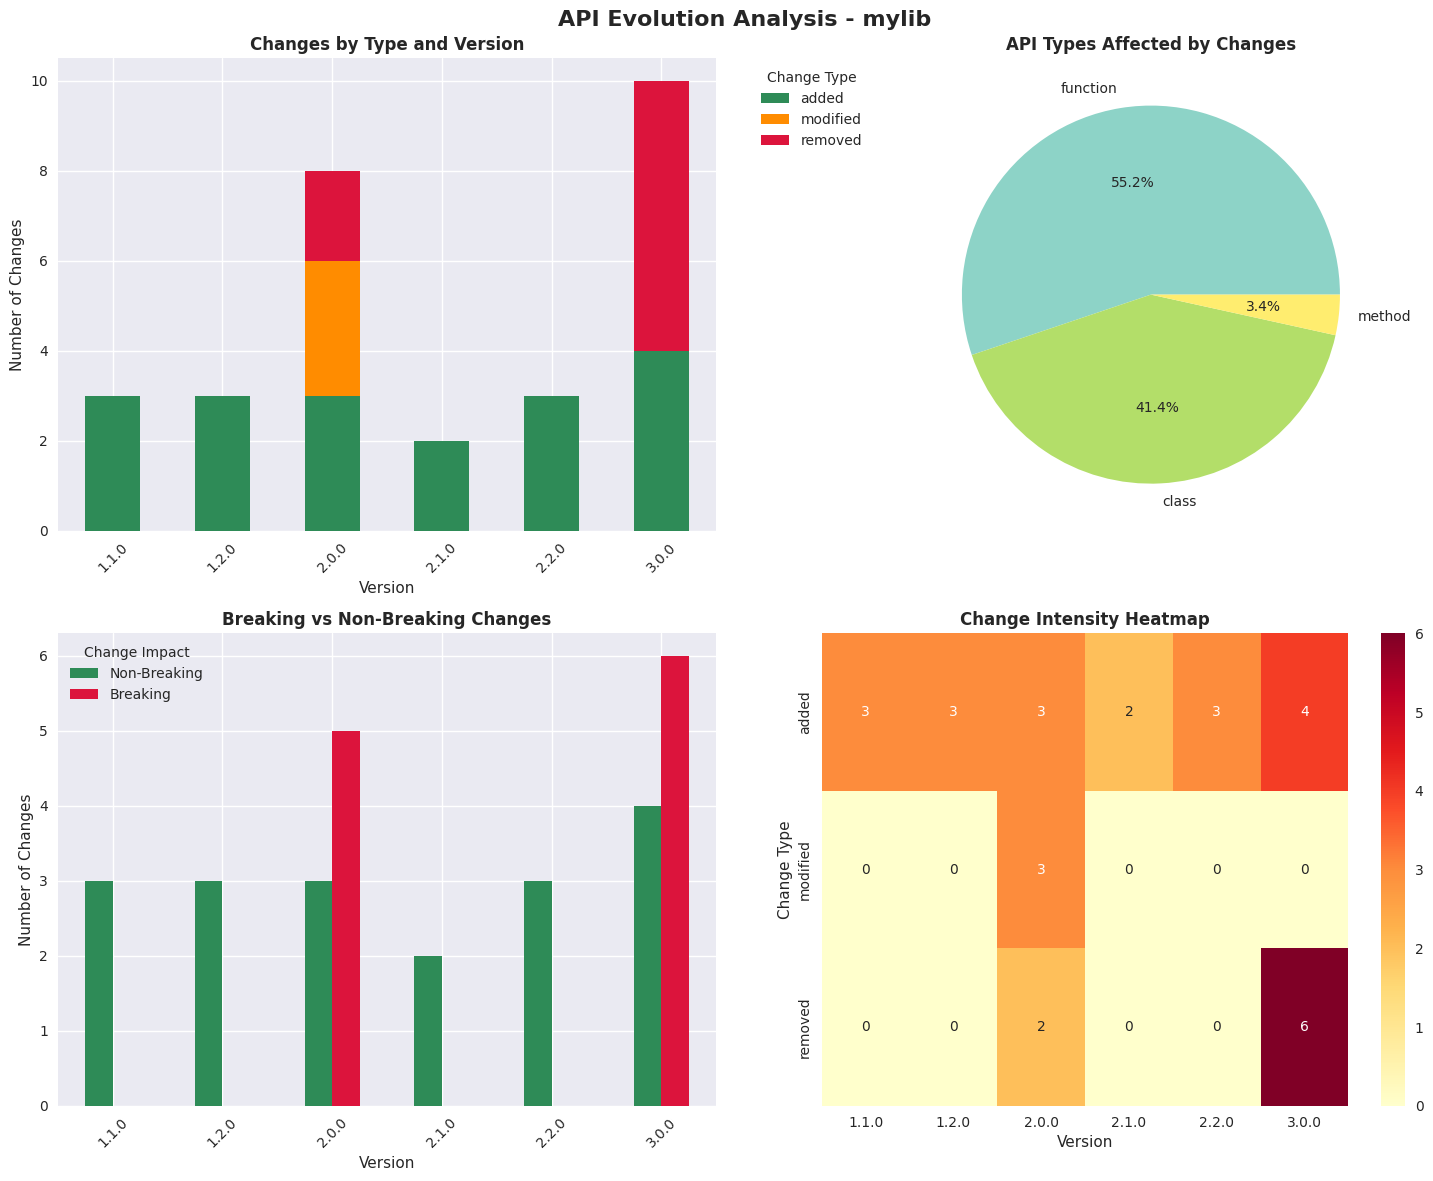

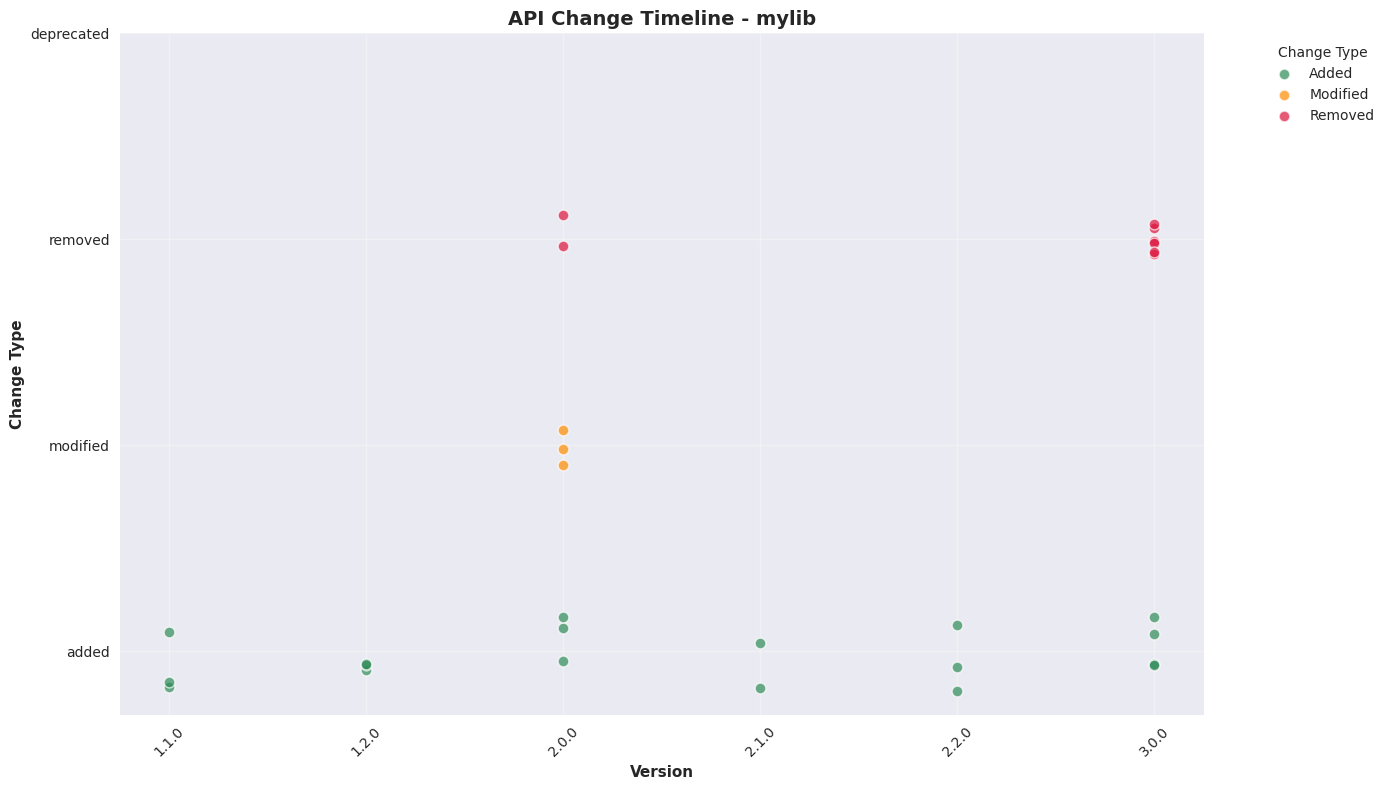

📊 Static visualizations created!


In [24]:
def create_static_visualizations(result):
    """Create publication-quality static visualizations with matplotlib/seaborn."""
    
    if not HAS_MPL:
        print("⚠️  Matplotlib/Seaborn not available. Please install with: pip install matplotlib seaborn")
        return
    
    # Prepare data
    change_data = []
    for change in result.changes:
        change_data.append({
            'version': change.to_version,
            'change_type': change.change_type.value,
            'api_type': change.element.type.value,
            'is_breaking': not change.is_backwards_compatible
        })
    
    df = pd.DataFrame(change_data)
    
    if df.empty:
        print("No data available for static visualizations")
        return
    
    # Create a figure with multiple subplots
    plt.style.use('seaborn-v0_8')  # Use updated seaborn style
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'API Evolution Analysis - {result.package_name}', fontsize=16, fontweight='bold')
    
    # 1. Change types over versions (stacked bar)
    ax1 = axes[0, 0]
    change_pivot = df.groupby(['version', 'change_type']).size().unstack(fill_value=0)
    change_pivot.plot(kind='bar', stacked=True, ax=ax1, 
                     color=['#2E8B57', '#FF8C00', '#DC143C', '#B8860B'])
    ax1.set_title('Changes by Type and Version', fontweight='bold')
    ax1.set_xlabel('Version')
    ax1.set_ylabel('Number of Changes')
    ax1.legend(title='Change Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. API types affected (pie chart)
    ax2 = axes[0, 1]
    api_counts = df['api_type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(api_counts)))
    wedges, texts, autotexts = ax2.pie(api_counts.values, labels=api_counts.index, 
                                       autopct='%1.1f%%', colors=colors)
    ax2.set_title('API Types Affected by Changes', fontweight='bold')
    
    # 3. Breaking vs non-breaking changes
    ax3 = axes[1, 0]
    breaking_counts = df.groupby(['version', 'is_breaking']).size().unstack(fill_value=0)
    breaking_counts.plot(kind='bar', ax=ax3, color=['#2E8B57', '#DC143C'])
    ax3.set_title('Breaking vs Non-Breaking Changes', fontweight='bold')
    ax3.set_xlabel('Version')
    ax3.set_ylabel('Number of Changes')
    ax3.legend(['Non-Breaking', 'Breaking'], title='Change Impact')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Change velocity heatmap
    ax4 = axes[1, 1]
    # Create a pivot table for heatmap
    heatmap_data = df.groupby(['version', 'change_type']).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data.T, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
    ax4.set_title('Change Intensity Heatmap', fontweight='bold')
    ax4.set_xlabel('Version')
    ax4.set_ylabel('Change Type')
    
    plt.tight_layout()
    plt.show()
    
    # Create a separate figure for timeline visualization
    plt.figure(figsize=(14, 8))
    
    # Timeline scatter plot
    change_type_colors = {'added': '#2E8B57', 'modified': '#FF8C00', 
                         'removed': '#DC143C', 'deprecated': '#B8860B'}
    
    for i, (change_type, color) in enumerate(change_type_colors.items()):
        type_data = df[df['change_type'] == change_type]
        if not type_data.empty:
            # Create numeric positions for versions
            version_positions = {v: i for i, v in enumerate(sorted(df['version'].unique()))}
            x_positions = [version_positions[v] for v in type_data['version']]
            y_positions = np.random.normal(i, 0.1, len(type_data))  # Add some jitter
            
            plt.scatter(x_positions, y_positions, c=color, label=change_type.title(), 
                       s=60, alpha=0.7, edgecolors='white', linewidth=1)
    
    plt.xlabel('Version', fontweight='bold')
    plt.ylabel('Change Type', fontweight='bold')
    plt.title(f'API Change Timeline - {result.package_name}', fontsize=14, fontweight='bold')
    plt.legend(title='Change Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set x-axis labels
    version_labels = sorted(df['version'].unique())
    plt.xticks(range(len(version_labels)), version_labels, rotation=45)
    
    # Set y-axis labels
    plt.yticks(range(len(change_type_colors)), list(change_type_colors.keys()))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("📊 Static visualizations created!")

# Create static visualizations
create_static_visualizations(demo_result)

## 6. API Lifecycle Analysis

Understanding the complete lifecycle of individual APIs helps identify stability patterns and plan deprecations.

In [25]:
def create_api_lifecycle_chart(result):
    """Create a Gantt-style chart showing the lifecycle of each API."""
    
    # Build lifecycle data for each unique API
    api_lifecycles = {}
    
    # First, collect all APIs and their versions
    all_apis = set()
    for elements in result.api_elements.values():
        for element in elements:
            all_apis.add(element.full_name)
    
    # For each API, find its lifecycle
    version_order = {v.version: i for i, v in enumerate(sorted(result.versions, key=lambda x: x.version))}
    
    for api_name in all_apis:
        lifecycle = {
            'name': api_name,
            'introduced': None,
            'removed': None,
            'versions_present': [],
            'modifications': []
        }
        
        # Find when API was introduced and removed
        for change in result.changes:
            if change.element.full_name == api_name:
                if change.change_type == ChangeType.ADDED:
                    lifecycle['introduced'] = change.to_version
                elif change.change_type == ChangeType.REMOVED:
                    lifecycle['removed'] = change.to_version
                elif change.change_type == ChangeType.MODIFIED:
                    lifecycle['modifications'].append(change.to_version)
        
        # Find all versions where API exists
        for version, elements in result.api_elements.items():
            for element in elements:
                if element.full_name == api_name:
                    lifecycle['versions_present'].append(version)
                    break
        
        # If no explicit introduction found, assume it was introduced in first version it appears
        if lifecycle['introduced'] is None and lifecycle['versions_present']:
            lifecycle['introduced'] = min(lifecycle['versions_present'], 
                                       key=lambda v: version_order.get(v, 999))
        
        api_lifecycles[api_name] = lifecycle
    
    # Create the Gantt chart
    fig = go.Figure()
    
    # Sort APIs by introduction version for better visualization
    sorted_apis = sorted(api_lifecycles.items(), 
                        key=lambda x: version_order.get(x[1]['introduced'], 999))
    
    colors = px.colors.qualitative.Set3
    api_types = {}
    
    # Determine API type for coloring
    for version, elements in result.api_elements.items():
        for element in elements:
            if element.full_name not in api_types:
                api_types[element.full_name] = element.type.value
    
    type_colors = {
        'function': '#1f77b4',
        'class': '#ff7f0e',
        'method': '#2ca02c', 
        'property': '#d62728',
        'constant': '#9467bd',
        'module': '#8c564b'
    }
    
    for i, (api_name, lifecycle) in enumerate(sorted_apis[:20]):  # Limit to first 20 for readability
        if not lifecycle['versions_present']:
            continue
            
        # Determine start and end positions
        start_pos = version_order.get(lifecycle['introduced'], 0)
        if lifecycle['removed']:
            end_pos = version_order.get(lifecycle['removed'], len(version_order) - 1)
        else:
            end_pos = len(version_order) - 1
        
        api_type = api_types.get(api_name, 'function')
        color = type_colors.get(api_type, '#1f77b4')
        
        # Add main lifecycle bar
        fig.add_trace(go.Scatter(
            x=[start_pos, end_pos],
            y=[i, i],
            mode='lines',
            line=dict(color=color, width=8),
            name=api_type if api_type not in [trace.name for trace in fig.data] else "",
            legendgroup=api_type,
            showlegend=api_type not in [trace.name for trace in fig.data],
            hovertemplate=f"<b>{api_name}</b><br>" +
                         f"Type: {api_type}<br>" +
                         f"Introduced: v{lifecycle['introduced']}<br>" +
                         f"Removed: {'v' + lifecycle['removed'] if lifecycle['removed'] else 'Still Active'}<br>" +
                         f"Modifications: {len(lifecycle['modifications'])}<br>" +
                         "<extra></extra>"
        ))
        
        # Add modification markers
        for mod_version in lifecycle['modifications']:
            mod_pos = version_order.get(mod_version, 0)
            fig.add_trace(go.Scatter(
                x=[mod_pos],
                y=[i],
                mode='markers',
                marker=dict(color='red', size=10, symbol='diamond'),
                name='Modification' if 'Modification' not in [trace.name for trace in fig.data] else "",
                legendgroup='modifications',
                showlegend='Modification' not in [trace.name for trace in fig.data],
                hovertemplate=f"<b>{api_name}</b><br>" +
                             f"Modified in: v{mod_version}<br>" +
                             "<extra></extra>"
            ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': f'API Lifecycle Timeline - {result.package_name}',
            'x': 0.5,
            'font': {'size': 18}
        },
        xaxis_title='Version',
        yaxis_title='API Elements',
        height=max(600, len(sorted_apis[:20]) * 30),
        hovermode='closest'
    )
    
    # Set up x-axis
    version_labels = [v.version for v in sorted(result.versions, key=lambda x: x.version)]
    fig.update_xaxes(
        tickmode='array',
        tickvals=list(range(len(version_labels))),
        ticktext=version_labels
    )
    
    # Set up y-axis
    api_names = [name for name, _ in sorted_apis[:20]]
    fig.update_yaxes(
        tickmode='array',
        tickvals=list(range(len(api_names))),
        ticktext=[name.split('.')[-1] for name in api_names]  # Show just the API name, not full path
    )
    
    return fig

# Create the API lifecycle chart
lifecycle_fig = create_api_lifecycle_chart(demo_result)
if lifecycle_fig:
    lifecycle_fig.show()
    print("📊 API lifecycle chart created!")
    print("🔍 Red diamonds indicate API modifications")
    print("📈 Different colors represent different API types")
else:
    print("❌ Could not create API lifecycle visualization")

📊 API lifecycle chart created!
🔍 Red diamonds indicate API modifications
📈 Different colors represent different API types


## 7. Summary and Next Steps

This notebook demonstrated various ways to visualize API evolution data using PyPevol. Here's what we covered:

### 📊 Visualization Types Created:
1. **Interactive Timeline**: Shows when APIs were added, modified, or removed
2. **API Type Distribution**: Reveals the composition of your API over time  
3. **Change Patterns Dashboard**: Multi-panel view of change trends and impacts
4. **Static Publication Plots**: High-quality plots for reports and papers
5. **API Lifecycle Charts**: Gantt-style view of individual API lifecycles

### 🎨 Visualization Libraries Used:
- **Plotly**: Interactive, web-ready visualizations with hover details and zoom
- **Matplotlib + Seaborn**: Publication-quality static plots with fine control
- **Pandas**: Data manipulation and aggregation for analysis

### 💡 Key Insights from Our Sample Data:
- Most changes occur during major version releases (2.0.0, 3.0.0)
- Breaking changes are concentrated in major versions
- Functions and classes are the most frequently changed API types
- Some APIs have short lifecycles, while others persist across many versions

### 🚀 Next Steps:
1. **Customize for Your Data**: Replace the sample data with your actual analysis results
2. **Add Filters**: Implement filtering by date ranges, API types, or change types
3. **Export Options**: Add functionality to save plots as PNG, PDF, or SVG
4. **Interactive Dashboards**: Consider building a web dashboard with Dash or Streamlit
5. **Automated Reports**: Set up automated visualization generation for CI/CD pipelines

### 📖 Tips for Effective API Evolution Visualization:
- Focus on the story you want to tell with your data
- Use consistent color schemes across related visualizations
- Include interactive elements for exploration
- Provide context with annotations and descriptions
- Consider your audience (developers, managers, researchers)

In [26]:
# Utility functions for customization and export

def save_visualization(fig, filename, format='html', width=1200, height=800):
    """Save a Plotly figure to file."""
    try:
        if format.lower() == 'html':
            fig.write_html(f"{filename}.html")
            print(f"✅ Saved interactive plot to {filename}.html")
        elif format.lower() in ['png', 'jpg', 'jpeg', 'svg', 'pdf']:
            fig.write_image(f"{filename}.{format}", width=width, height=height)
            print(f"✅ Saved static plot to {filename}.{format}")
        else:
            print(f"❌ Unsupported format: {format}")
    except Exception as e:
        print(f"❌ Error saving visualization: {e}")
        print("💡 For static formats, you may need to install kaleido: pip install kaleido")

def create_custom_color_scheme():
    """Create a custom color scheme for consistent branding."""
    return {
        'primary': '#2E86C1',      # Blue
        'secondary': '#28B463',    # Green  
        'accent': '#F39C12',       # Orange
        'warning': '#E74C3C',      # Red
        'info': '#8E44AD',         # Purple
        'neutral': '#95A5A6'       # Gray
    }

def filter_analysis_result(result, start_version=None, end_version=None, 
                          api_types=None, change_types=None):
    """Filter analysis results based on various criteria."""
    filtered_result = AnalysisResult(
        package_name=result.package_name,
        versions=result.versions.copy(),
        api_elements=result.api_elements.copy(),
        changes=result.changes.copy(),
        metadata=result.metadata.copy()
    )
    
    # Filter by version range
    if start_version or end_version:
        version_numbers = [v.version for v in result.versions]
        if start_version and start_version in version_numbers:
            start_idx = version_numbers.index(start_version)
            filtered_result.versions = filtered_result.versions[start_idx:]
        if end_version and end_version in version_numbers:
            end_idx = version_numbers.index(end_version) + 1
            filtered_result.versions = filtered_result.versions[:end_idx]
    
    # Filter changes
    if change_types:
        filtered_result.changes = [
            c for c in filtered_result.changes 
            if c.change_type in change_types
        ]
    
    if api_types:
        filtered_result.changes = [
            c for c in filtered_result.changes 
            if c.element.type in api_types
        ]
    
    return filtered_result

def export_data_summary(result, filename='api_evolution_summary'):
    """Export a summary of the analysis results to CSV and JSON."""
    try:
        # Create summary data
        summary_data = []
        for change in result.changes:
            summary_data.append({
                'version': change.to_version,
                'api_name': change.element.name,
                'api_full_name': change.element.full_name,
                'api_type': change.element.type.value,
                'change_type': change.change_type.value,
                'is_breaking': not change.is_backwards_compatible,
                'description': change.description,
                'module': change.element.module_path
            })
        
        # Save as CSV
        df = pd.DataFrame(summary_data)
        df.to_csv(f"{filename}.csv", index=False)
        print(f"✅ Exported data summary to {filename}.csv")
        
        # Save as JSON
        with open(f"{filename}.json", 'w') as f:
            json.dump({
                'package_name': result.package_name,
                'total_versions': len(result.versions),
                'total_changes': len(result.changes),
                'summary': result.generate_summary(),
                'changes': summary_data
            }, f, indent=2)
        print(f"✅ Exported data summary to {filename}.json")
        
    except Exception as e:
        print(f"❌ Error exporting data: {e}")

# Example usage:
print("🛠️  Utility functions loaded!")
print("📁 Use save_visualization(fig, 'my_chart') to save plots")
print("🎨 Use create_custom_color_scheme() for consistent colors") 
print("🔍 Use filter_analysis_result() to focus on specific data")
print("📊 Use export_data_summary() to save data for external analysis")

🛠️  Utility functions loaded!
📁 Use save_visualization(fig, 'my_chart') to save plots
🎨 Use create_custom_color_scheme() for consistent colors
🔍 Use filter_analysis_result() to focus on specific data
📊 Use export_data_summary() to save data for external analysis
